In [8]:
import geopandas as gpd
import numpy as np
import pandas as pd

In [3]:
# import
rj = gpd.read_file('/content/RJ_Municipios_2022.shp')

<Axes: >

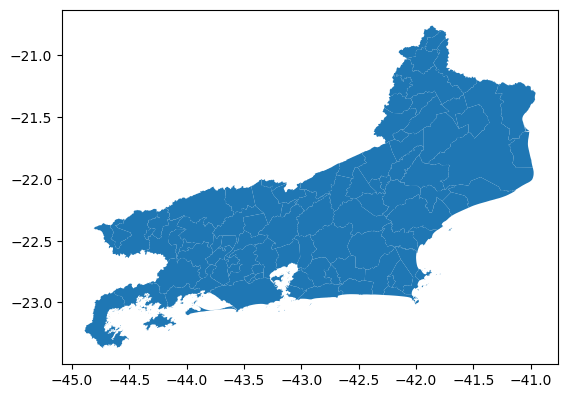

In [12]:
# filtering
rj.plot()

## Zonal Statistics w/ raster files

In [10]:
%pip install rasterio


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for rasterio from https://files.pythonhosted.org/packages/0b/92/7c2f152cb51d0e9aca768080daf3211e2dad1706b9f5669a17b6b87bfeeb/rasterio-1.3.10-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for affine from https://files.pythonhosted.org/packages/0b/f7/85273299ab57117850cc0a936c64151171fac4da49bc6fba0dad984a7c5f/affine-2.4.0-py3-none-any.whl.metadata
  Obtaining dependency information for snuggs>=1.4.1 from https://files.pythonhosted.org/packages/cc/0e/d27d6e806d6c0d1a2cfdc5d1f088e42339a0a54a09c3343f7f81ec8947ea/snuggs-1.4.7-py3-none-any.whl.metadata
  Obtaining dependency information for setuptools from https://files.pythonhosted.org/packages/f7/29/13965af254e3373bceae8fb9a0e6ea0d0e571171b80d6646932131d6439b/setuptools-69.5.1-py3-none-any.whl.metadata
  Obtaining dependency information for pyparsing>=2.1.6 from https://files.pythonhosted.org/packages/9d/


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show

ModuleNotFoundError: No module named 'matplotlib'

In [16]:
# downscale
# REMEMBER RAFAEL's POINT - Due to the rescaling method, we have measurement error in the interpolation.
# How would you fix this exercise, class?
 
from rasterio.enums import Resampling

output_file = '/content/flii_SouthAmerica_dr.tif'
input_file = '/content/flii_SouthAmerica.tif'

with rasterio.open(input_file) as src:
    # read metadata
    metadata = src.meta

    # specify new dimensions
    scale_factor = 0.1 # downscale by a factor of 10
    new_height = int(src.height * scale_factor)
    new_width = int(src.width * scale_factor)
    new_transform = src.transform * src.transform.scale(
        (src.width/new_width), (src.height/new_height)
    )
    metadata.update({
        'height':new_height,
        'width':new_width,
        'transform':new_transform,
        'nodata':-9999, # fixing nodata
        'dtype':'float32'
    })
    with rasterio.open(output_file, 'w', **metadata) as dst:
        # resampling data to target shape
        for i in range(1, src.count +1):
            dst.write(
                src.read(i,
                         out_shape=(src.count, new_height, new_width),
                         resampling = Resampling.bilinear
                ),
                indexes=i
            )

In [17]:
# read array
with rasterio.open(output_file) as src:
    print(src.crs)
    array = src.read(1)
    affine = src.transform

EPSG:4326


In [18]:
# remember, -9999 is np.nan!
array[array == -9999] = np.nan

In [22]:
from rasterio.mask import mask

rj = rj.to_crs('epsg:4326')
# lets crop RJ
with rasterio.open(output_file) as src:
    rj_array, rj_transform = mask(src, shapes=rj.geometry, crop=True, nodata=np.nan)

<Axes: >

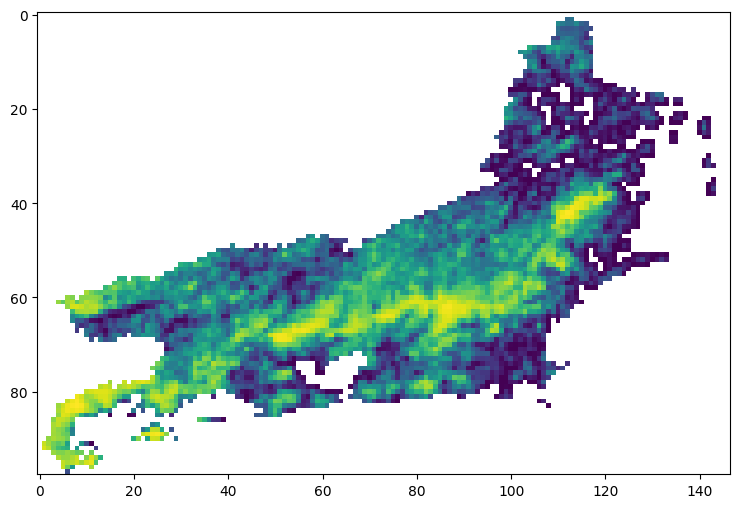

In [23]:
f,ax = plt.subplots(figsize=(10,6))
show(rj_array, ax=ax)

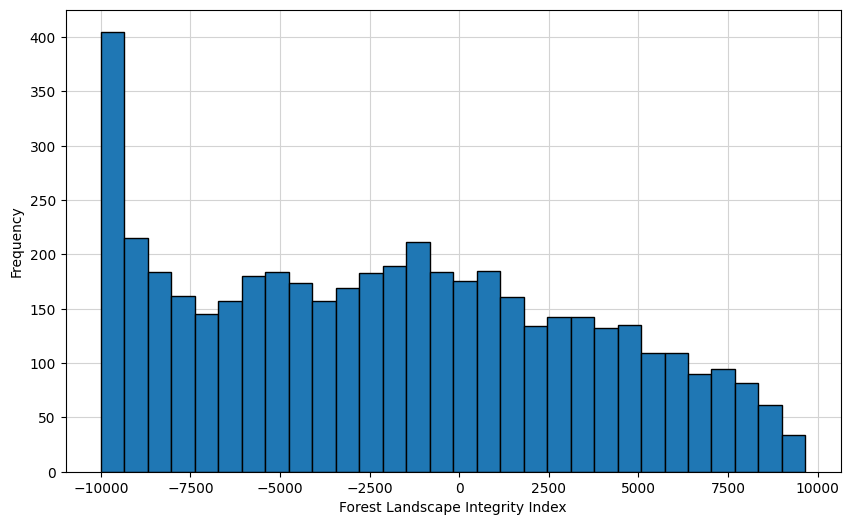

In [24]:
# lets check the data distribution!
f, ax = plt.subplots(figsize=(10,6))
ax.hist(rj_array[rj_array!= np.nan].reshape(-1,1), bins=30, edgecolor='k')
ax.set_xlabel('Forest Landscape Integrity Index')
ax.set_ylabel('Frequency')
ax.grid(color='lightgray')
ax.set_axisbelow(True)
plt.show()


In [27]:
from rasterstats import zonal_stats

rj_array[rj_array<0] = np.nan

zs1 = zonal_stats(rj, rj_array[0], affine=rj_transform, stats=['mean'], nodata=np.nan)
zs2 = zonal_stats(rj, rj_array[0], affine=rj_transform, stats=['mean'], nodata=np.nan, alltouched= True)
rj['mean_flii1'] = [x['mean'] for x in zs1]
rj['mean_flii2'] = [x['mean'] for x in zs2]

In [29]:
rj['mean_flii1'] = rj['mean_flii1']/1000
rj['mean_flii2'] = rj['mean_flii2']/1000

In [32]:
rj

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry,mean_flii1,mean_flii2
0,3300100,Angra dos Reis,RJ,813.420,"MULTIPOLYGON (((-44.51649 -23.03589, -44.51633...",6.120305,6.120305
1,3300159,Aperibé,RJ,94.542,"POLYGON ((-42.11437 -21.61204, -42.11394 -21.6...",NaN,NaN
2,3300209,Araruama,RJ,638.276,"POLYGON ((-42.28399 -22.93928, -42.28444 -22.9...",NaN,NaN
3,3300225,Areal,RJ,110.724,"POLYGON ((-43.09004 -22.23844, -43.09135 -22.2...",1.177625,1.177625
4,3300233,Armação dos Búzios,RJ,70.977,"MULTIPOLYGON (((-41.91872 -22.77162, -41.91854...",NaN,NaN
...,...,...,...,...,...,...,...
87,3306008,Três Rios,RJ,322.843,"POLYGON ((-43.23685 -22.13806, -43.23831 -22.1...",1.735875,1.735875
88,3306107,Valença,RJ,1300.767,"POLYGON ((-43.72940 -22.09312, -43.72927 -22.0...",1.524553,1.524553
89,3306156,Varre-Sai,RJ,201.938,"POLYGON ((-41.89492 -20.97015, -41.89490 -20.9...",0.231000,0.231000
90,3306206,Vassouras,RJ,536.073,"POLYGON ((-43.66409 -22.45808, -43.67771 -22.4...",1.286789,1.286789


<Axes: >

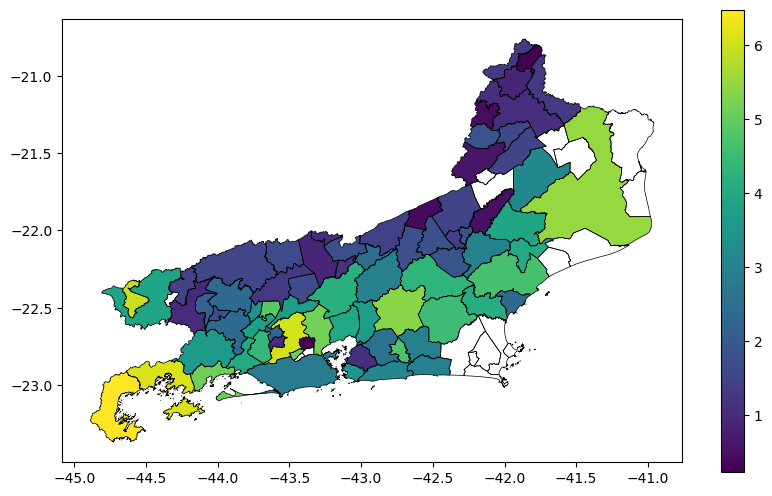

In [31]:
f, ax = plt.subplots(1,1 ,figsize=(10,6))
rj.plot(ax=ax, column='mean_flii2', cmap='viridis', legend=True)
rj.boundary.plot(ax=ax,lw=0.5,color='k')

## Zonal Statistics w/ another shapefile 

In [5]:
%pip install geopandas

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

  Obtaining dependency information for geopandas from https://files.pythonhosted.org/packages/3e/b0/69fa7a0f55122847506a42fea6988d03b34136938082f142151bc9d9f7e7/geopandas-0.14.4-py3-none-any.whl.metadata
  Obtaining dependency information for fiona>=1.8.21 from https://files.pythonhosted.org/packages/0c/a9/fca1698d2f5a1fbaf451659a7bde506bbf7daca72a21ba6201e557df6490/fiona-1.9.6-cp312-cp312-win_amd64.whl.metadata
     ---------------------------------------- 0.0/51.5 kB ? eta -:--:--
     ------- -------------------------------- 10.2/51.5 kB ? eta -:--:--
     -------------------------------------- 51.5/51.5 kB 878.6 kB/s eta 0:00:00
  Obtaining dependency information for numpy>=1.22 from https://files.pythonhosted.org/packages/16/2e/86f24451c2d530c88daf997cb8d6ac622c1d40d19f5a031ed68a4b73a374/numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata
    


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import geopandas as gpt

In [32]:
# importing second data
rj = gpd.read_file(r"C:\Users\B39313\economiaambiental\Limite_de_Bairros\Limite_de_Bairros.shp")
ismfi = gpd.read_file(r'C:\Users\B39313\Downloads\ismfi_grade\ismfi_grade\indice.shp')

In [18]:
import matplotlib.pyplot as plt

<Axes: >

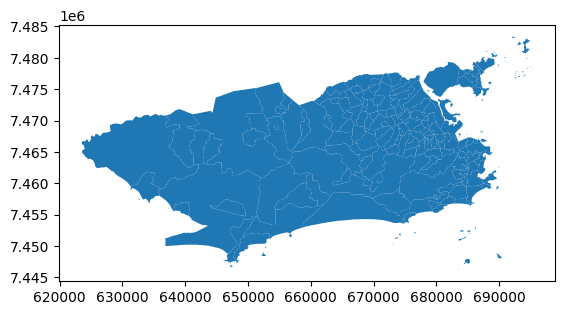

In [55]:
rj.plot()

(619940.0160978794, 698942.9358587307, 7444399.431338712, 7485238.984202462)

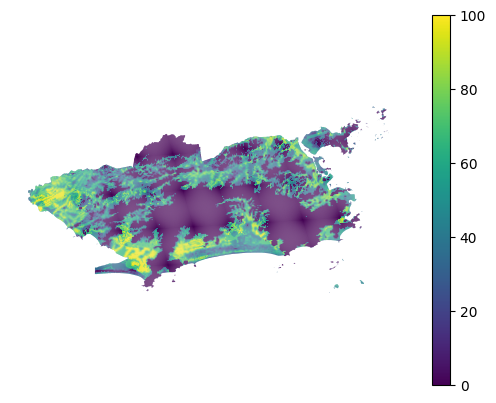

In [56]:
ismfi.plot(column='ISMFI_corr', legend=True)
plt.axis('off')

In [57]:
# FIXING CRS
rj = rj.to_crs(ismfi.crs)

In [67]:
# Joining databases
merged = rj.sjoin(ismfi[['geometry','ISMFI_corr']],how='left',predicate='intersects')
merged

,objectid,área,nome,regiao_adm,area_plane,codbairro,codra,codbnum,link,rp,cod_rp,codbairro_,st_areasha,st_perimet,geometry,index_right,ISMFI_corr
0,325,1.705685e+06,Paquetá,PAQUETA,1,013,21,13,Paqueta&area=013,Centro,1.1,13,1.705689e+06,24841.459984,"MULTIPOLYGON (((694511.597 7483033.908, 694510...",31653,24.600999
0,325,1.705685e+06,Paquetá,PAQUETA,1,013,21,13,Paqueta&area=013,Centro,1.1,13,1.705689e+06,24841.459984,"MULTIPOLYGON (((694511.597 7483033.908, 694510...",31654,24.928217
0,325,1.705685e+06,Paquetá,PAQUETA,1,013,21,13,Paqueta&area=013,Centro,1.1,13,1.705689e+06,24841.459984,"MULTIPOLYGON (((694511.597 7483033.908, 694510...",31655,28.467524
0,325,1.705685e+06,Paquetá,PAQUETA,1,013,21,13,Paqueta&area=013,Centro,1.1,13,1.705689e+06,24841.459984,"MULTIPOLYGON (((694511.597 7483033.908, 694510...",31656,37.257764
0,325,1.705685e+06,Paquetá,PAQUETA,1,013,21,13,Paqueta&area=013,Centro,1.1,13,1.705689e+06,24841.459984,"MULTIPOLYGON (((694511.597 7483033.908, 694510...",31657,34.314112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,894,7.714616e+06,Ilha de Guaratiba,GUARATIBA,5,164,26,164,Ilha de Guaratiba &area=164,Guaratiba,5.4,164,7.714637e+06,13955.136856,"POLYGON ((646478.944 7457463.030, 646565.580 7...",8453,36.082034
163,894,7.714616e+06,Ilha de Guaratiba,GUARATIBA,5,164,26,164,Ilha de Guaratiba &area=164,Guaratiba,5.4,164,7.714637e+06,13955.136856,"POLYGON ((646478.944 7457463.030, 646565.580 7...",7776,18.476684
163,894,7.714616e+06,Ilha de Guaratiba,GUARATIBA,5,164,26,164,Ilha de Guaratiba &area=164,Guaratiba,5.4,164,7.714637e+06,13955.136856,"POLYGON ((646478.944 7457463.030, 646565.580 7...",7777,21.985894
163,894,7.714616e+06,Ilha de Guaratiba,GUARATIBA,5,164,26,164,Ilha de Guaratiba &area=164,Guaratiba,5.4,164,7.714637e+06,13955.136856,"POLYGON ((646478.944 7457463.030, 646565.580 7...",7778,21.617264


In [68]:
# merging dataframes
merged = merged[['codbairro','regiao_adm','ISMFI_corr']].groupby(['codbairro','regiao_adm']).agg('mean').reset_index().merge(rj[['codbairro','geometry']])

<Axes: >

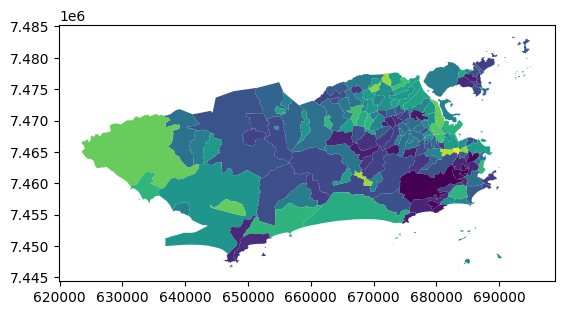

In [70]:
# turning it back to geodataframe
merged = gpd.GeoDataFrame(merged)
merged.plot(column='ISMFI_corr')

In [71]:
# Filtrando os resultados para regioes_adm igual a "COMPLEXO DA MARE" ou "JACAREZINHO"
filtered_merged = merged.query('regiao_adm == "COMPLEXO DA MARE" or regiao_adm == "JACAREZINHO" or regiao_adm=="RAMOS" or regiao_adm =="MEIER"')
print(filtered_merged)


    codbairro        regiao_adm  ISMFI_corr  \
38        039             RAMOS   53.628685   
39        040             RAMOS   37.114108   
40        041             RAMOS   39.670996   
41        042             RAMOS   33.718669   
50        051             MEIER   36.299492   
56        057             MEIER   18.944962   
57        058             MEIER   26.263873   
58        059             MEIER   20.463079   
59        060             MEIER   20.741365   
60        061             MEIER   17.288706   
61        062             MEIER    6.111280   
62        063             MEIER   29.446320   
63        064             MEIER   29.420993   
64        065             MEIER   25.511059   
65        066             MEIER   27.361927   
66        067             MEIER    4.125603   
67        068             MEIER   32.669185   
68        069             MEIER   14.520528   
69        070             MEIER   28.506718   
70        071             MEIER   25.449720   
154       155

<Axes: >

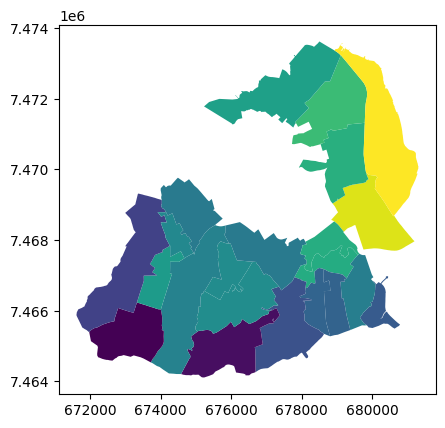

In [72]:
#Plotting!
filtered_merged = gpd.GeoDataFrame(filtered_merged)
filtered_merged.plot(column='ISMFI_corr')

In [73]:
# Dissolving
merged = merged[['regiao_adm','geometry','ISMFI_corr']].dissolve(by='regiao_adm',aggfunc='mean').reset_index()
merged

,regiao_adm,geometry,ISMFI_corr
0,ANCHIETA,"POLYGON ((666856.067 7474160.043, 666984.128 7...",20.427554
1,BANGU,"POLYGON ((656953.642 7465095.024, 657034.532 7...",32.440105
2,BARRA DA TIJUCA,"MULTIPOLYGON (((652551.173 7448903.453, 652555...",23.629728
3,BOTAFOGO,"MULTIPOLYGON (((684580.728 7459534.009, 684548...",20.041672
4,CAMPO GRANDE,"POLYGON ((643004.223 7463074.103, 642951.313 7...",24.117170
5,CENTRO,"MULTIPOLYGON (((687053.602 7464818.066, 687021...",35.406754
6,CIDADE DE DEUS,"POLYGON ((668009.766 7462017.727, 668043.226 7...",64.416457
7,COMPLEXO DA MARE,"POLYGON ((681285.606 7469879.614, 681223.196 7...",56.391716
8,COMPLEXO DO ALEMÃO,"POLYGON ((677818.671 7471301.757, 677830.511 7...",4.646393
9,COPACABANA,"MULTIPOLYGON (((686300.069 7456822.145, 686293...",17.842660


<Axes: >

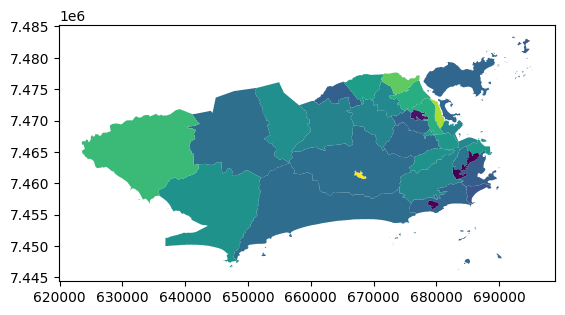

In [74]:
#Plotting!
merged.plot(column='ISMFI_corr')

In [75]:
merged_original=merged.copy()

In [79]:
merged_original

,regiao_adm,geometry,ISMFI_corr
0,ANCHIETA,"POLYGON ((666856.067 7474160.043, 666984.128 7...",20.427554
1,BANGU,"POLYGON ((656953.642 7465095.024, 657034.532 7...",32.440105
2,BARRA DA TIJUCA,"MULTIPOLYGON (((652551.173 7448903.453, 652555...",23.629728
3,BOTAFOGO,"MULTIPOLYGON (((684580.728 7459534.009, 684548...",20.041672
4,CAMPO GRANDE,"POLYGON ((643004.223 7463074.103, 642951.313 7...",24.117170
5,CENTRO,"MULTIPOLYGON (((687053.602 7464818.066, 687021...",35.406754
6,CIDADE DE DEUS,"POLYGON ((668009.766 7462017.727, 668043.226 7...",64.416457
7,COMPLEXO DA MARE,"POLYGON ((681285.606 7469879.614, 681223.196 7...",56.391716
8,COMPLEXO DO ALEMÃO,"POLYGON ((677818.671 7471301.757, 677830.511 7...",4.646393
9,COPACABANA,"MULTIPOLYGON (((686300.069 7456822.145, 686293...",17.842660


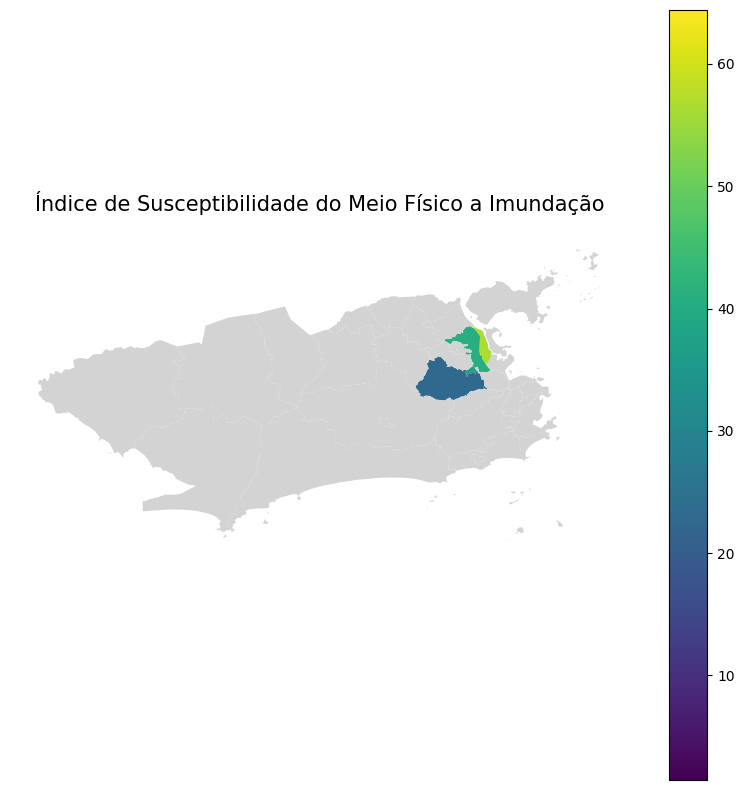

In [82]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors


highlight_mask = merged['regiao_adm'].isin(['COMPLEXO DA MARE', 'JACAREZINHO', "RAMOS", "MEIER"])

merged['color'] = merged['ISMFI_corr']
merged.loc[~highlight_mask, 'color'] = float('nan')  

# Define a colormap
cmap = plt.cm.viridis  
cmap.set_bad('lightgrey') 


norm = colors.Normalize(vmin=merged['ISMFI_corr'].min(), vmax=merged['ISMFI_corr'].max())

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
merged.plot(ax=ax, column='color', cmap=cmap, norm=norm, legend=True, missing_kwds={"color": "lightgrey", "edgecolor": "none"})
ax.axis('off') 
ax.set_title("Índice de Susceptibilidade do Meio Físico a Imundação", fontsize=15)

plt.show()


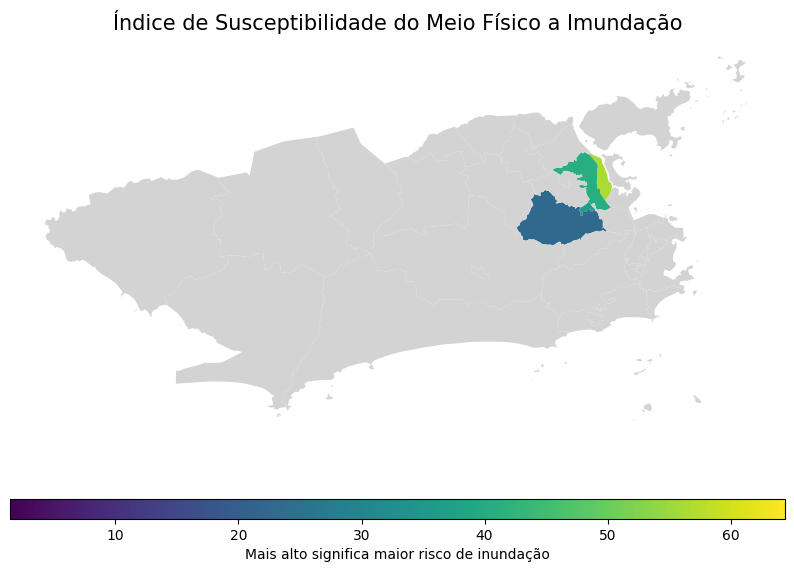

In [85]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define a mask for areas of interest
highlight_mask = merged['regiao_adm'].isin(['COMPLEXO DA MARE', 'JACAREZINHO', "RAMOS", "MEIER"])

# Assign 'ISMFI_corr' for highlighted regions, NaN for others
merged['color'] = merged['ISMFI_corr']
merged.loc[~highlight_mask, 'color'] = float('nan')  # Use NaN for non-highlighted regions

# Setup the colormap and normalization
cmap = plt.cm.viridis
cmap.set_bad('lightgrey')  # NaN values will be grey
norm = colors.Normalize(vmin=merged['ISMFI_corr'].min(), vmax=merged['ISMFI_corr'].max())

# Create plot
fig, ax = plt.subplots(figsize=(10, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.6)  # Adjust the colorbar size and position
pc = merged.plot(column='color', ax=ax, cmap=cmap, norm=norm, legend=False,
                 missing_kwds={"color": "lightgrey", "edgecolor": "none"})

# Creating a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  

# Add colorbar to the plot
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label('Mais alto significa maior risco de inundação')
ax.set_title("Índice de Susceptibilidade do Meio Físico a Imundação", fontsize=15)

ax.axis('off')
plt.show()





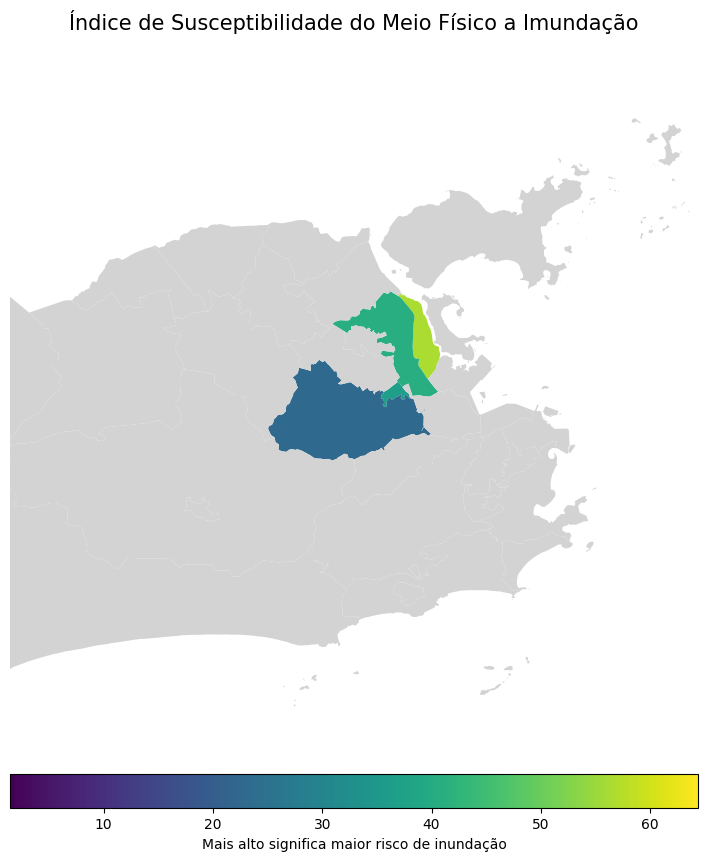

In [90]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define a mask for areas of interest
highlight_mask = merged['regiao_adm'].isin(['COMPLEXO DA MARE', 'JACAREZINHO', "RAMOS", "MEIER"])

# Calculate bounds for the highlighted regions
highlighted = merged[highlight_mask]
xmin, ymin, xmax, ymax = highlighted.total_bounds

# Add padding to expand the bounds
# Increase these padding values to lower the zoom level further
padding = 1.5  # adjust as needed
xpad = padding * (xmax - xmin)
ypad = padding * (ymax - ymin)

# Assign 'ISMFI_corr' for highlighted regions, NaN for others
merged['color'] = merged['ISMFI_corr']
merged.loc[~highlight_mask, 'color'] = float('nan')  

# Setup the colormap and normalization
cmap = plt.cm.viridis
cmap.set_bad('lightgrey')  
norm = colors.Normalize(vmin=merged['ISMFI_corr'].min(), vmax=merged['ISMFI_corr'].max())

# Create plot
fig, ax = plt.subplots(figsize=(10, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.6)  # Adjust the colorbar size and position
pc = merged.plot(column='color', ax=ax, cmap=cmap, norm=norm, legend=False,
                 missing_kwds={"color": "lightgrey", "edgecolor": "none"})

# Set the x and y limits to zoom out a bit by adding padding
ax.set_xlim(xmin - xpad, xmax + xpad)
ax.set_ylim(ymin - ypad, ymax + ypad)

# Creating a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Necessary for the colorbar

# Add colorbar to the plot
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label('Mais alto significa maior risco de inundação')
ax.set_title("Índice de Susceptibilidade do Meio Físico a Imundação", fontsize=15)

ax.axis('off')
plt.show()



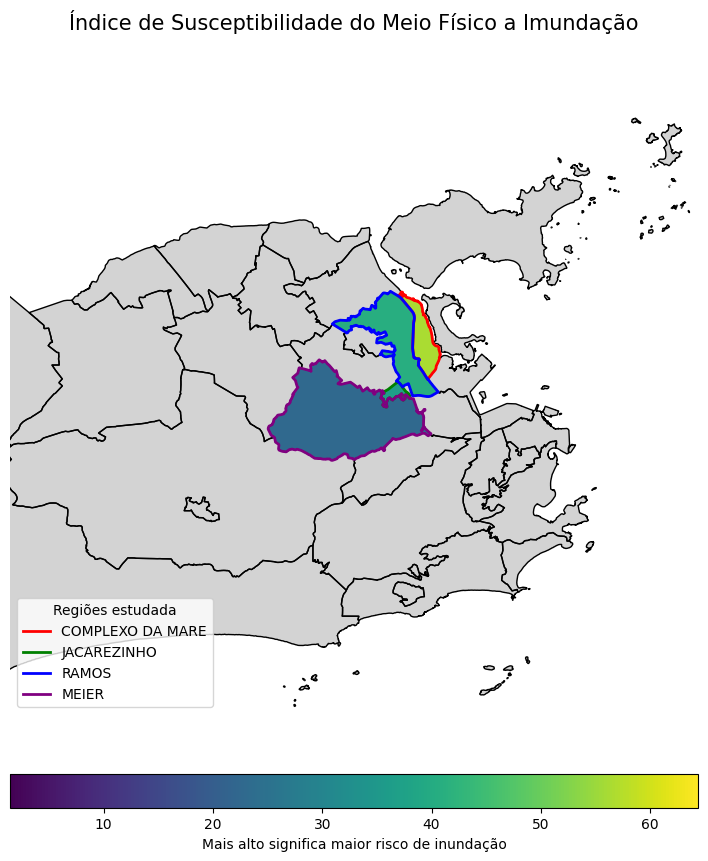

In [101]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D


# Define the regions to highlight
highlighted_regions = ['COMPLEXO DA MARE', 'JACAREZINHO', "RAMOS", "MEIER"]
highlight_mask = merged['regiao_adm'].isin(highlighted_regions)

# Assign 'ISMFI_corr' for all regions but set NaN for non-highlighted regions for grey color
merged['color'] = merged['ISMFI_corr']
merged.loc[~highlight_mask, 'color'] = float('nan')  # NaN for non-highlighted regions

# Setup colormap and normalization
cmap = plt.cm.viridis
cmap.set_bad('lightgrey')  # Grey for NaN values
norm = colors.Normalize(vmin=merged['ISMFI_corr'].min(), vmax=merged['ISMFI_corr'].max())

# Create plot
fig, ax = plt.subplots(figsize=(10, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.6)  # Adjust the colorbar size and position

# Plot the data
pc = merged.plot(column='color', ax=ax, cmap=cmap, norm=norm, legend=False, 
                 missing_kwds={"color": "lightgrey", "edgecolor": "none"})

# Plot black contours for non-highlighted regions
non_highlighted = merged[~highlight_mask]
non_highlighted.boundary.plot(ax=ax, color='black', linewidth=1)

# Plot contours for each highlighted region with unique colors
colors = ['red', 'green', 'blue', 'purple']
color_dict = dict(zip(highlighted_regions, colors))
for region, color in color_dict.items():
    region_data = merged[merged['regiao_adm'] == region]
    region_data.boundary.plot(ax=ax, color=color, linewidth=2)

# Create a custom legend for highlighted regions
legend_elements = [Line2D([0], [0], color=color, lw=2, label=region) for region, color in color_dict.items()]
ax.legend(handles=legend_elements, title="Regiões estudada", loc='lower left')

# ScalarMappable and Colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Necessary for the colorbar
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label('Mais alto significa maior risco de inundação')

# Calculate the total bounds for the highlighted regions
highlighted = merged[highlight_mask]
xmin, ymin, xmax, ymax = highlighted.total_bounds

# Add padding to expand the bounds for less zoom
padding = 1.5 
xpad = padding * (xmax - xmin)
ypad = padding * (ymax - ymin)
ax.set_xlim(xmin - xpad, xmax + xpad)
ax.set_ylim(ymin - ypad, ymax + ypad)

# Title and axis off
ax.set_title("Índice de Susceptibilidade do Meio Físico a Imundação", fontsize=15)
ax.axis('off')
plt.show()

